# RECAP: 
#### From the previous notebook, we have:
* Perfomed mini EDAs on "Restaurants" category of the [Yelp dataset ](https://www.yelp.com/dataset/challenge). 
    -  Don't forget to checkout the interactive heatmap of restaurants in Toronto and Montreals based on the star ratings!   
    - Plotted the top 20 categories in the Yelp dataset.
    - Bar plotted the distribution of stars amongst the Restaurants category based on unique business id
    - Horizontal bar plot of the cities with the most Yelp restaurant reviews
    - Heatmap of all the restaurants in Toronto, Montréal, and Mississauga
    - Interactive heatmap of restaurants in Toronto and Montréal based on 1,2,3,4 and 5 star ratings using Folium!
  
  
* Started preparing the data for predictive modelling by merging both business and reviews dataset based filtered on the restaurants category only.
    -  QUICK STATS: There are 54,618 unique business and 3,221,418 restaurant reviews by 908,921 unique users
    -  Plot the bar and boxplot for the Star Rating Distribution in 'Restaurants' Category
    -  Recategorize the data into negative and positive reviews denoted by 0 and 1 respectively
    -  Due to an unbalanced dataset, I performed random undersampling for the positive class by drawing 670,000 reviews from each class respectively for a total of 1,340,000 reviews.
    

* Text Preprocessing
    -  Defined two functions.
    -  First function to remove all punctuations, numbers, converts reviews to lower case and handles negation terms.
    -  Second function that "tokenizes" the cleaned text from the first function.
    -  Also defined an alternate function that has added functionality of the first function including removing stopwords, stemming/lemmatizing reviews. 
    - Finally, created a new dataframe and csv containing the resampled, cleaned reviews.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import seaborn as sns
import time  
import re
from textblob import TextBlob
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm, tqdm_pandas
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [60]:
df = pd.read_csv('resampled_clean_reviews.csv',index_col=0)
df.head()

,reviews,target
0,ate there times hit and miss st time wife had ...,0
1,weve lived nearby for little over months and h...,0
2,ken our bartender hates his job and the patron...,0
3,went here while back waited minutes to get sta...,0
4,was here exclusively for desserts last night c...,0


In [3]:
#Reshuffling the data
#df = df.sample(frac=1, axis=0).reset_index(drop=True)

In [4]:
df.isnull().any()

reviews     True
target     False
dtype: bool

In [5]:
#Check data for any null values.
len(df.iloc[df[df.isnull().any(axis=1)].index,:])

138

In [6]:
#Turns out we have lost some reviews after cleaning the data
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339862 entries, 0 to 1339861
Data columns (total 2 columns):
reviews    1339862 non-null object
target     1339862 non-null int64
dtypes: int64(1), object(1)
memory usage: 20.4+ MB


In [7]:
#We have 669,941 negative and 669,921 positive reviews
df.groupby('target').size()

target
0    669941
1    669921
dtype: int64

## Preparation for data visualization

In order to visualize some data later, I need the term frequency data. What kind of words are used in the reviews, and how many times it is used in entire corpus. I used count vectorizer to calculate the term frequencies for visualizes purposes for now.

There are other parameters in the count vectorizer function, such as removing stop words, limiting the maximum number of terms. However, in order to get a full picture of the dataset, I will implement with stop words included, and not limiting the maximum number of terms.

In [8]:
%%time
vect = CountVectorizer()
vect.fit(df.reviews)

Wall time: 1min 53s


In [9]:
len(vect.vocabulary_) #The count vectorizer has extracted 583,701 words out of the corpus! 

583701

Now, let's get the term frequency for each class!

In [10]:
%%time
neg_mat = vect.transform(df[df.target == 0].reviews)
pos_mat = vect.transform(df[df.target == 1].reviews)
neg_tf = np.sum(neg_mat,axis=0)
pos_tf = np.sum(pos_mat,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()

Wall time: 2min 14s


In [11]:
term_freq_df.to_csv('term_freq.csv',encoding='utf-8')

In [12]:
df2=pd.read_csv('term_freq.csv',header=None, skiprows=1,index_col=0)
df2.head()

,1,2
0,,
aa,80,128
aaa,130,139
aaaa,2,7
aaaaa,0,5
aaaaaa,2,3


In [13]:
df2.columns = ['negative', 'positive']
df2['total'] = df2['negative'] + df2['positive']

In [14]:
df2.head()

,negative,positive,total
0,,,
aa,80,128,208
aaa,130,139,269
aaaa,2,7,9
aaaaa,0,5,5
aaaaaa,2,3,5


In [15]:
df2.sort_values(by='total', ascending=False).iloc[:20]

,negative,positive,total
0,,,
the,4456008,3488684,7944692
and,2726627,2423706,5150333
to,2240481,1308664,3549145
was,1993963,1215007,3208970
of,1214095,995988,2210083
not,1530626,666123,2196749
it,1239590,845669,2085259
for,1038830,769237,1808067
is,803317,967319,1770636


As we can see above, there are many stop words amongst our top 20 tokens/terms. Since stop words have high frequencies in both positive and negative reviews, let's see what are the words that are most frequent when stop words are removed. Also, let's limit the number of features to 10,000

In [16]:
%%time
vect1 = CountVectorizer(stop_words='english',max_features=10000)
vect1.fit(df.reviews)

Wall time: 1min 43s


In [17]:
document_matrix = vect1.transform(df.reviews)

In [18]:
(document_matrix).shape

(1339862, 10000)

In [19]:
%%time
neg_batches = np.linspace(0,669941,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch)
    print(neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

74437 entries' term freuquency calculated
148875 entries' term freuquency calculated
223313 entries' term freuquency calculated
297751 entries' term freuquency calculated
372189 entries' term freuquency calculated
446627 entries' term freuquency calculated
521065 entries' term freuquency calculated
595503 entries' term freuquency calculated
669941 entries' term freuquency calculated
Wall time: 23.2 s


In [20]:
%%time
pos_batches = np.linspace(669941,1339862,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch)
    print(pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

744376 entries' term freuquency calculated
818812 entries' term freuquency calculated
893248 entries' term freuquency calculated
967683 entries' term freuquency calculated
1042119 entries' term freuquency calculated
1116555 entries' term freuquency calculated
1190990 entries' term freuquency calculated
1265426 entries' term freuquency calculated
1339862 entries' term freuquency calculated
Wall time: 22.6 s


In [21]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
tf = pd.DataFrame([neg,pos],columns=vect1.get_feature_names()).transpose()
tf.columns = ['negative', 'positive']
tf['total'] = tf['negative'] + tf['positive']
tf.sort_values(by='total', ascending=False).iloc[:20]

,negative,positive,total
food,640559,456884,1097443
place,380888,385133,766021
good,325862,416193,742055
service,327005,243324,570329
like,325863,207098,532961
just,337267,190687,527954
great,121712,381180,502892
time,264970,185454,450424
did,315788,122162,437950
ordered,245081,122734,367815


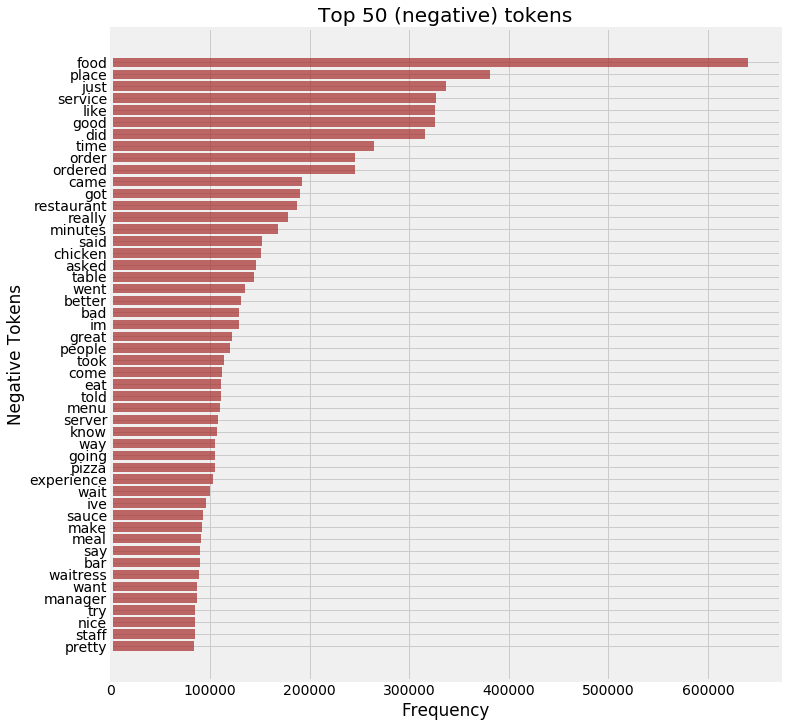

In [22]:
plt.figure(figsize=(12,12))
plt.style.use('fivethirtyeight')

negwords = tf.sort_values(by='negative', ascending=False)['negative'][:50].sort_values()
y_pos = np.arange(50)

plt.barh(y_pos, negwords, color='brown',alpha=0.7)

plt.yticks(y_pos, negwords.index)
plt.ylabel('Negative Tokens')
plt.xlabel('Frequency')
plt.title('Top 50 (negative) tokens')

plt.show()

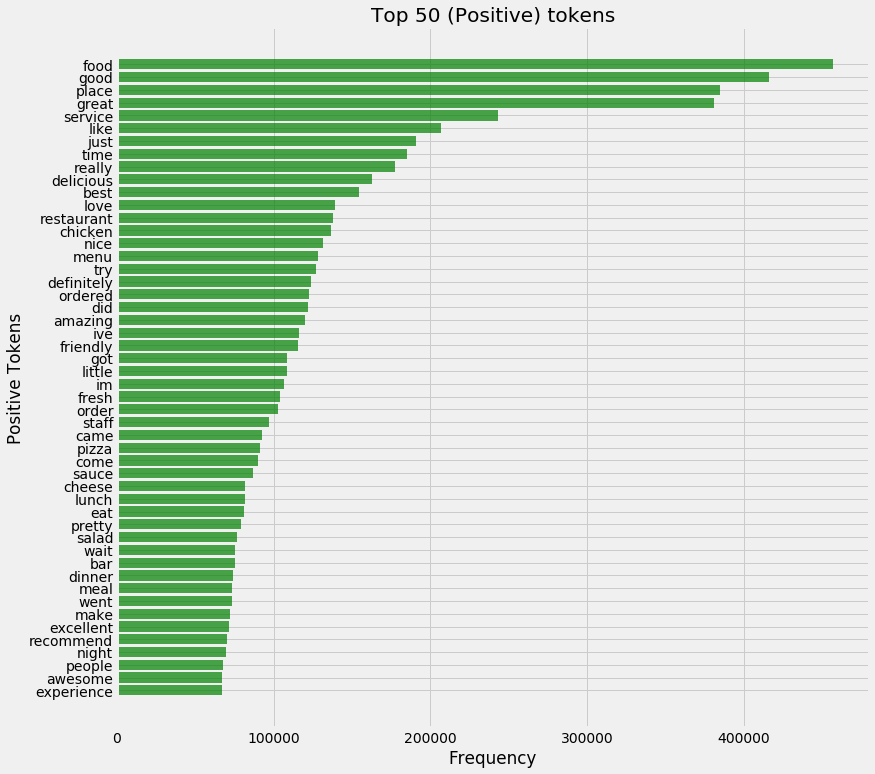

In [23]:
plt.figure(figsize=(12,12))
plt.style.use('fivethirtyeight')

poswords = tf.sort_values(by='positive', ascending=False)['positive'][:50].sort_values()
y_pos = np.arange(50)

plt.barh(y_pos, poswords, color='green',alpha=0.7)

plt.yticks(y_pos, poswords.index)
plt.ylabel('Positive Tokens')
plt.xlabel('Frequency')
plt.title('Top 50 (Positive) tokens')

plt.show()

### Relationship between negative and positive frequency

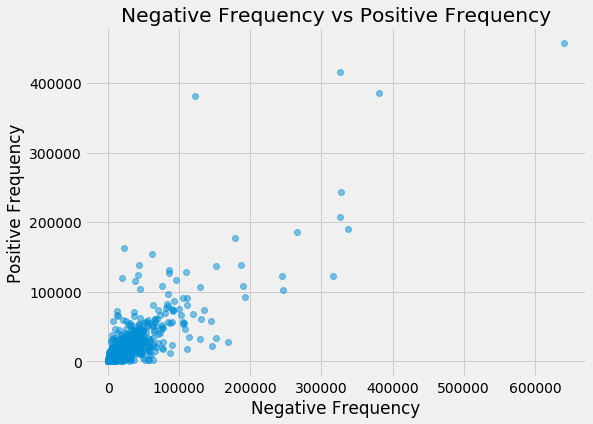

In [24]:
plt.figure(figsize=(8,6))

ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=tf)

plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

plt.show()

From the graph above, it doesn't seem like there is any meaningful relationship between positive and negative frequency

Taking inspiration from [Ricky Kim's](https://towardsdatascience.com/@rickykim78) sentiment analysis on twitter data, we'll try to find a more meaningful metric that will allow us to characterise important tokens in each class. Intuitively, the frequency of a word in one class over the other can be a reasonable measure of how important the word is in characterizing the class. First, we'll define the positive rate as $$\text{pos_rate} = \frac{\text{frequency of a positive word }}{\text{total occurence of a word (in positive and negative reviews)}}$$

In [25]:
tf['pos_rate'] = tf['positive']/tf['total']
tf.sort_values(by='pos_rate', ascending=False).head(5)

,negative,positive,total,pos_rate
yummmm,14,336,350,0.960000
bombcom,21,367,388,0.945876
musttry,32,547,579,0.944732
yummm,21,355,376,0.944149
addicting,63,1054,1117,0.943599


As we can see, words with the highest positive rate metric has relatively very low frequency in negative reviews. Also, the overall frequency of these words also makes it unlikely that we can use it as a reliable metric for positive reviews.

Alternatively, another metric is the frequency a words occurs in the class. This is defined as $${\text{Percentage of positive frequency}} = \frac {\text{frequency of a positive word}} {\Sigma \text{ positive words}}$$

In [26]:
tf['pos_freq_pct'] = tf['positive']/tf['positive'].sum()
tf.sort_values(by='pos_rate', ascending=False).head(5)

,negative,positive,total,pos_rate,pos_freq_pct
yummmm,14,336,350,0.960000,0.000012
bombcom,21,367,388,0.945876,0.000013
musttry,32,547,579,0.944732,0.000019
yummm,21,355,376,0.944149,0.000012
addicting,63,1054,1117,0.943599,0.000037


Since the positive frequency percentage is just scaled over the total sum of positive words, it has the same rank as the positive rate. 

So, to come up with an effective metric that reflects both positive rate and positive frequency percentage, we will utilize [harmonic mean](https://towardsdatascience.com/on-average-youre-using-the-wrong-average-geometric-harmonic-means-in-data-analysis-2a703e21ea0) instead of the arithmetic mean together with the CDF(Cumulative Distribution Function) of both positive rate and positive frequency rate. CDF can be explained as "distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x". The harmonic mean for our purpose helps us to draw a relationship between two rates or ratios of different units such as our two measures above that differs only in their denominator. The harmonic mean H of a positive real number is defined as: $${H} = \frac {n}{\sum_{i=1}^{n}\ \frac{1}{x_i}}$$

As we can see below, the word "*perfect*" has a pos_rate_normcdf of 0.990362 and pos_freq_pct_normcdf of 0.999991. This means that roughly 99.04% of the tokens will take a pos_rate value less or equal to 0.896272 and 99.99% will take pos_freq_pct value of 0.002001 or less.


We see that pos_normcdf_hmean metric provides a more meaningful measure of how important a word is within the class!  Next, we'll apply the same calculation to negative words.

In [27]:
from scipy.stats import norm
from scipy.stats import hmean

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

#cdf of positive rate
tf['pos_rate_normcdf'] = normcdf(tf['pos_rate'])

#cdf of the positive rate frequency
tf['pos_freq_pct_normcdf'] = normcdf(tf['pos_freq_pct'])

#harmonic mean of the cdf of positive rate and cdf of positive rate frequency
tf['pos_normcdf_hmean'] = hmean([tf['pos_rate_normcdf'], tf['pos_freq_pct_normcdf']])

tf.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
perfect,6672,57650,64322,0.896272,0.002001,0.990362,0.999991,0.995153
delicious,22337,163015,185352,0.879489,0.005658,0.987819,1.000000,0.993872
amazing,19685,120387,140072,0.859465,0.004178,0.984042,1.000000,0.991957
excellent,12291,71739,84030,0.853731,0.002490,0.982791,1.000000,0.991321
fantastic,5762,37639,43401,0.867238,0.001306,0.985613,0.996779,0.991165
awesome,11965,66854,78819,0.848197,0.002320,0.981505,1.000000,0.990666
loved,9153,47043,56196,0.837124,0.001633,0.978684,0.999731,0.989096
favorite,13999,64835,78834,0.822424,0.002250,0.974386,0.999999,0.987026
perfectly,4275,30475,34750,0.876978,0.001058,0.987392,0.984724,0.986057
wonderful,6221,32793,39014,0.840544,0.001138,0.979592,0.990475,0.985004


In [28]:
tf['neg_rate'] = tf['negative']/tf['total']
tf['neg_freq_pct'] = tf['negative']/tf['negative'].sum()
tf['neg_rate_normcdf'] = normcdf(tf['neg_rate'])
tf['neg_freq_pct_normcdf'] = normcdf(tf['neg_freq_pct'])
tf['neg_normcdf_hmean'] = hmean([tf['neg_rate_normcdf'], tf['neg_freq_pct_normcdf']])
tf.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
worst,63841,1481,65322,0.022672,0.000051,0.011297,0.456305,0.022047,0.977328,0.001778,0.988703,0.999954,0.994297
horrible,57126,1764,58890,0.029954,0.000061,0.012489,0.465111,0.024326,0.970046,0.001591,0.987511,0.999745,0.993590
terrible,56067,2244,58311,0.038483,0.000078,0.014024,0.480085,0.027252,0.961517,0.001561,0.985976,0.999671,0.992776
rude,51335,2194,53529,0.040987,0.000076,0.014504,0.478523,0.028155,0.959013,0.001429,0.985496,0.999030,0.992217
bland,48835,4894,53729,0.091087,0.000170,0.027530,0.562681,0.052491,0.908913,0.001360,0.972470,0.998343,0.985237
poor,37102,2405,39507,0.060875,0.000083,0.018846,0.485114,0.036282,0.939125,0.001033,0.981154,0.985198,0.983172
manager,87029,11984,99013,0.121035,0.000416,0.039203,0.762232,0.074570,0.878965,0.002423,0.960797,1.000000,0.980007
waited,60732,8870,69602,0.127439,0.000308,0.042161,0.680615,0.079403,0.872561,0.001691,0.957839,0.999896,0.978416
asked,146296,22526,168822,0.133430,0.000782,0.045089,0.938196,0.086044,0.866570,0.004073,0.954911,1.000000,0.976935
told,111382,17167,128549,0.133544,0.000596,0.045147,0.868591,0.085832,0.866456,0.003101,0.954853,1.000000,0.976905


## Let's check out the CDF Harmonic mean of positive and negative reviews

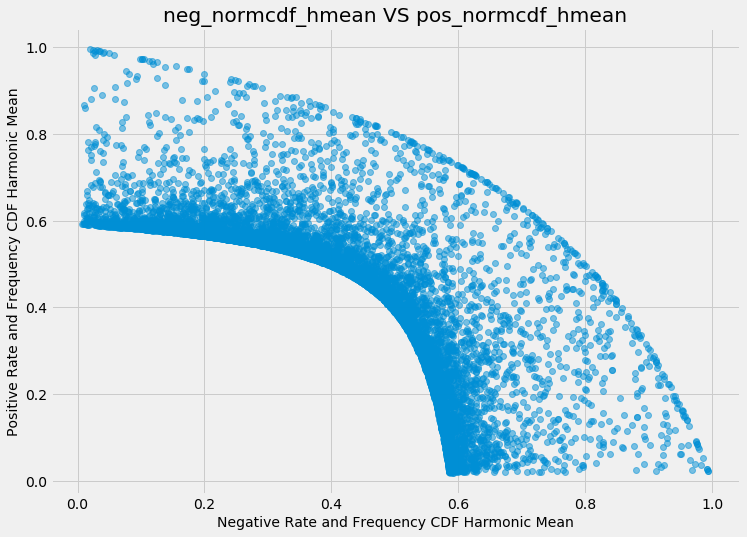

In [29]:
plt.figure(figsize=(11,8))

ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=tf)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean', size=14)
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean',size=14)
plt.title('neg_normcdf_hmean VS pos_normcdf_hmean')

plt.show()

In [30]:
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
from bokeh.resources import INLINE

output_notebook()
color_mapper = LinearColorMapper(palette='Magma256', low=min(tf.pos_normcdf_hmean), high=max(tf.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.5,source=tf,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

The interactive bokeh plot may not be displayed, but an example of it looks as the following:
Words that are closer to the upper corner on the y-axis represents words that are strongly associated with positive reviews while words that are on the bottom right corner on the x-axis represents words that are strongly associated with negative reviews.
[![BOKEH_plot.png](https://s9.postimg.cc/rix3l0sxr/BOKEH_plot.png)](https://postimg.cc/image/mk9l6hp4r/)

# Time to evaluate different models!

#### Previously, I tried to run the algorithms based on the ~1.34million reviews dataset. However, due to computational power, I decided to down sample the original resampled, cleaned dataset.

In [31]:
from sklearn.utils import resample
df_negative = df[df.target==0]
df_positive = df[df.target==1]

df_negative_downsampled = resample(df_negative,replace=False,n_samples=335000,random_state=335)
df_positive_downsampled = resample(df_positive,replace=False,n_samples=335000,random_state=335)
df_downsampled = pd.concat([df_negative_downsampled,df_positive_downsampled])
df_downsampled.to_csv('resized_reviews.csv',encoding='utf-8')
df_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670000 entries, 336004 to 1080388
Data columns (total 2 columns):
reviews    670000 non-null object
target     670000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [32]:
df = pd.read_csv('resized_reviews.csv',index_col=0)
df.head()

,reviews,target
336004,the only thing would go here for is the food a...,0
436981,weve been anticipating salam opening for while...,0
25904,the stars are really for the location set up a...,0
558674,note based on my experience from winterlicious...,0
433119,while must agree with previous reviewers that ...,0


## Train/Validation/Test Set
I decided to split my data with 94% as the training set, 3% for the validation/hold-out and test set. The rationale is because we have over 700,000 reviews. as such, 2% of the whole data represents about 21k reviews. This is more than sufficient to evaluate the model.


We can also run k-fold CV on the training set to get an anbiased evaluation of a model. However, I decided to use the validation set so that I can test the models on an interative process. 

In [33]:
SEED = 3350


x = df.reviews
y = df.target

#defining our training, validation and test set
x_train, x_validation_test, y_train, y_validation_test = train_test_split(x, y, test_size=.06, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=.5, random_state=SEED)



In [34]:

print('The Training set has {0} reviews with {1:.2f}% negative, {2:.2f}% positive reviews'.format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1))*100))

print('The Validation set has {0} entries with {1:.2f}% negative, {2:.2f}% positive reviews'.format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1))*100))

print('The test set has a total of {0} reviews with {1:.2f}% negative, {2:.2f}% positive reviews'.format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1))*100))

The Training set has 629800 reviews with 50.00% negative, 50.00% positive reviews
The Validation set has 20100 entries with 49.85% negative, 50.15% positive reviews
The test set has a total of 20100 reviews with 50.00% negative, 50.00% positive reviews


## Benchmark / Baseline

It is always useful to have a baseline reference when comparing various machine learning algorithms. As we see from the result above, our validation set has a majority class of 50.15%, which means even if a classifer predicts negative for every validation datum, it will yield 50.15% accuracy.

Before diving into comparing various classification model including, logistic regression, naive bayes, decision trees, random forest, and support vector machine, I'd like to use an out-of-the-box model, [Textblob](http://textblob.readthedocs.io/en/dev/) to see how well it does.

In [35]:
tb_result = [TextBlob(text).sentiment.polarity for text in x_validation]
tb_pred = [0 if n < 0 else 1 for n in tb_result]

In [36]:
conf_mat = np.array(confusion_matrix(y_validation, tb_pred, labels=[1,0]))
confusion = pd.DataFrame(conf_mat, index=['Expected Positive', 'Expected Negative'],
                         columns=['Predicted: Positive','Predicted: Negative'])

print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tb_pred)*100))
print("-"*60)
print("Confusion Matrix:\n")
print(confusion)
print("-"*60)
print("Classification Report\n")
print(classification_report(y_validation, tb_pred))

Accuracy Score: 71.09%
------------------------------------------------------------
Confusion Matrix:

                   Predicted: Positive  Predicted: Negative
Expected Positive                 9881                  200
Expected Negative                 5610                 4409
------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

          0       0.96      0.44      0.60     10019
          1       0.64      0.98      0.77     10081

avg / total       0.80      0.71      0.69     20100



#### The TextBlob sentiment analysis yielded 71.06% accuracy on the validation set, which is 21.01% more accurate than null accuracy of 50.05%! It is quite impressive for an out-of-the-box model!

## Feature Extraction

In classification, items are represented by their features. In our case, our features are words from the document. And to use these features in our ML algorithms, we'll have to convert them to a numerical representation. One of the methods is the Bag of Words (BoW) model. The bag of words model ignores order of words and also grammar. A list of vocabulary is created once we have the corpus (text data). Then each data entry is represented as a numerical vector based on the vocabulary built form the corpus.

### CountVectorizer

We will use CountVectorizer to "convert text into a matrix of token counts". Very simply, we count the apperance of the words in each text. However, with over 1.3 million reviews, the number of vocabulary can get too big to process. Precisely, the shape of the training data is defined as $\text{(# of reviews in training set)} \times \text{(# of vocabularies)}$. In our case, the shape of our trianing data is $700,000 \times 583,701 $. As such, I will limit and also vary the number of vocabularies to see how it affects performance of the models

One contentious topic for sentiment analysis is the use of stop words. How will the exclusion/inclusion of stopwords affect our model? It is assumed that using stopwords will typically improve model performance. But, I will use a basic linear classifier, logistic regression to evaluate different count vectors and explore the effect of stop words. Once I have the optimal number of features and have decided whether to use stop words, I will be exploring other ML models.

First, let's define two functions:
1. To iteratively train on different number of features
2. To check the accuracy of logistic regression on the validation set.

In [37]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / len(x_test) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / len(x_test)
    else:
        null_accuracy = 1 - (len(x_test[y_test == 0]) / (len(x_test)))
    t0 = time.time()
    pfit = pipeline.fit(x_train, y_train)
    y_pred = pfit.predict(x_test)
    traintest_time = time.time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("Null Accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Accuracy Score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("Model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("Train and Test time= {0:.2f}s".format(traintest_time))
    print("-"*60)
    return accuracy, traintest_time

In [38]:
#Instantiate CountVectorizer (vectorizer)
vect = CountVectorizer()

#Instantiate model
logit = LogisticRegression()

#we'll start with 10,000 features and end with 30,000 features with a stepsize of 5,000
n_features = np.arange(10000,30001,5000)

#Using stopwords from nltk.corpus
#stopwords = set(stopwords.words('english'))

def nfeature_checker(vectorizer=vect, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=logit):
    result = []
    print(classifier, "\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

pl= Pipeline([
        ('vectorizer', vect),
        ('classifier', logit)
    ])
accuracy_summary(pipeline=pl, x_train=x_validation, y_train=y_validation, x_test=x_validation_test, y_test = y_validation_test)

In [39]:
%%time
print("UNIGRAM WITHOUT STOP WORDS\n")
unigram_nostopwords = nfeature_checker(stop_words='english')

UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 94.29%
Model is 44.14% more accurate than null accuracy
Train and Test time= 116.01s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 94.26%
Model is 44.11% more accurate than null accuracy
Train and Test time= 206.16s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 94.32%
Model is 44.17% more accurate than null accuracy
Train and Test time= 227.11s
------------------------------------------------------------
Validation result for 25000 features
Null 

In [40]:
%%time
print("UNIGRAM WITH STOP WORDS\n")
unigram_stopwords = nfeature_checker()

UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 95.23%
Model is 45.07% more accurate than null accuracy
Train and Test time= 311.33s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 95.23%
Model is 45.07% more accurate than null accuracy
Train and Test time= 383.67s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 95.22%
Model is 45.07% more accurate than null accuracy
Train and Test time= 369.68s
------------------------------------------------------------
Validation result for 25000 features
Null Acc

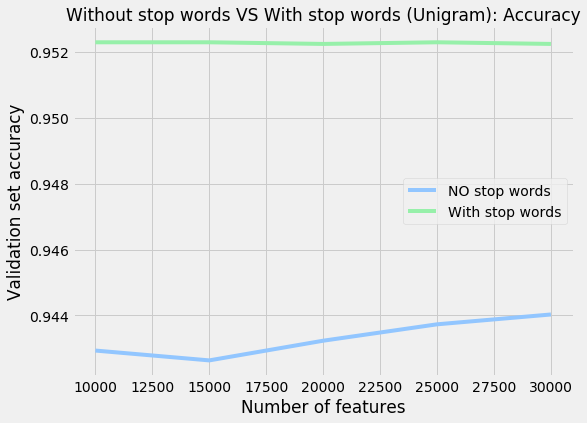

In [42]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn-pastel')

#Unigram with NO stop words
plot_uninsw = pd.DataFrame(unigram_nostopwords,columns=['n_features','validation_accuracy','train_test_time'])

#Unigram with stop words
plot_unisw = pd.DataFrame(unigram_stopwords,columns=['n_features','validation_accuracy','train_test_time'])


plt.plot(plot_uninsw.n_features, plot_uninsw.validation_accuracy, label='NO stop words')
plt.plot(plot_unisw.n_features, plot_unisw.validation_accuracy,label='With stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy", size=17 )
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


plt.show()

Interestingly, the inclusion of the stop words in the reviews tends to yield a higher accuracy than when stop words are excluded!

Next, I will also explore bigram and trigram to see how it affects performance.

### Bigram

In [43]:
%%time
print("BIGRAM WITH STOP WORDS\n")
bigram = nfeature_checker(ngram_range=(1, 2))

BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 95.89%
Model is 45.73% more accurate than null accuracy
Train and Test time= 647.85s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 96.05%
Model is 45.90% more accurate than null accuracy
Train and Test time= 660.88s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 96.00%
Model is 45.85% more accurate than null accuracy
Train and Test time= 482.33s
------------------------------------------------------------
Validation result for 25000 features
Null Accu

### Trigram

In [44]:
%%time
print("TRIGRAM WITH STOP WORDS\n")
trigram = nfeature_checker(ngram_range=(1, 3))

TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 96.01%
Model is 45.86% more accurate than null accuracy
Train and Test time= 583.48s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 96.10%
Model is 45.95% more accurate than null accuracy
Train and Test time= 694.62s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 96.10%
Model is 45.95% more accurate than null accuracy
Train and Test time= 777.06s
------------------------------------------------------------
Validation result for 25000 features
Null Acc

## TFIDF Vectorizer

In [45]:
tvec = TfidfVectorizer()

In [46]:
%%time
print ("UNIGRAM WITH STOP WORDS (Tfidf)\n")
uni_tfidf = nfeature_checker(vectorizer=tvec)

UNIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 95.38%
Model is 45.22% more accurate than null accuracy
Train and Test time= 83.00s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 95.44%
Model is 45.29% more accurate than null accuracy
Train and Test time= 88.38s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 95.48%
Model is 45.33% more accurate than null accuracy
Train and Test time= 92.09s
------------------------------------------------------------
Validation result for 25000 features
Nul

In [47]:
%%time
print ("BIGRAM WITH STOP WORDS (Tfidf)\n")
bi_tfidf = nfeature_checker(vectorizer=tvec, ngram_range=(1,2))

BIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 96.20%
Model is 46.04% more accurate than null accuracy
Train and Test time= 209.62s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 96.45%
Model is 46.30% more accurate than null accuracy
Train and Test time= 216.47s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 96.56%
Model is 46.41% more accurate than null accuracy
Train and Test time= 224.36s
------------------------------------------------------------
Validation result for 25000 features
N

In [48]:
%%time
print ("TRIGRAM WITH STOP WORDS (Tfidf)\n")
tri_tfidf = nfeature_checker(vectorizer=tvec, ngram_range=(1,3))

TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Validation result for 10000 features
Null Accuracy: 50.15%
Accuracy Score: 96.21%
Model is 46.06% more accurate than null accuracy
Train and Test time= 459.15s
------------------------------------------------------------
Validation result for 15000 features
Null Accuracy: 50.15%
Accuracy Score: 96.44%
Model is 46.29% more accurate than null accuracy
Train and Test time= 471.31s
------------------------------------------------------------
Validation result for 20000 features
Null Accuracy: 50.15%
Accuracy Score: 96.56%
Model is 46.41% more accurate than null accuracy
Train and Test time= 491.36s
------------------------------------------------------------
Validation result for 25000 features


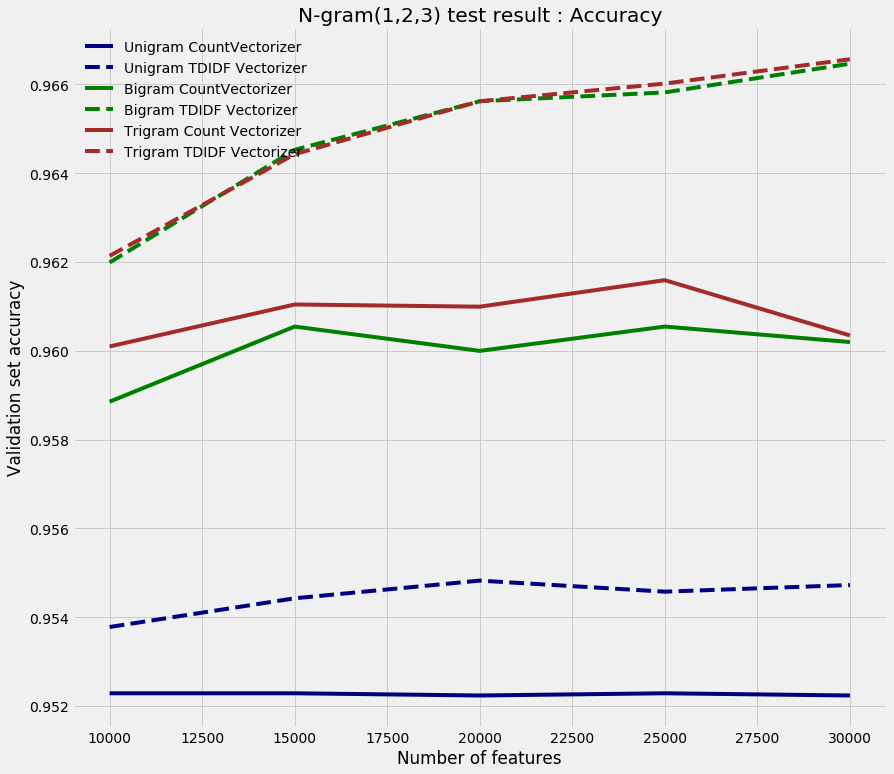

In [49]:
plt.figure(figsize=(13,12))

uni_plot = pd.DataFrame(uni_tfidf,columns=['n_features','validation_accuracy','train_test_time'])
bi_plot = pd.DataFrame(bi_tfidf,columns=['n_features','validation_accuracy','train_test_time'])
tri_plot = pd.DataFrame(tri_tfidf,columns=['n_features','validation_accuracy','train_test_time'])
bisw_plot = pd.DataFrame(bigram,columns=['n_features','validation_accuracy','train_test_time'])
trisw_plot = pd.DataFrame(trigram,columns=['n_features','validation_accuracy','train_test_time'])

plt.plot(plot_unisw.n_features, plot_unisw.validation_accuracy, label='Unigram CountVectorizer',color='navy')
plt.plot(uni_plot.n_features, uni_plot.validation_accuracy,label='Unigram TDIDF Vectorizer',linestyle='--', color='navy')
plt.plot(bisw_plot.n_features, bisw_plot.validation_accuracy,label='Bigram CountVectorizer',color='green')
plt.plot(bi_plot.n_features, bi_plot.validation_accuracy,label='Bigram TDIDF Vectorizer',linestyle='--',color='green')
plt.plot(trisw_plot.n_features, trisw_plot.validation_accuracy, label='Trigram Count Vectorizer',color='brown')
plt.plot(tri_plot.n_features, tri_plot.validation_accuracy, label='Trigram TDIDF Vectorizer',linestyle='--',color='brown')
plt.title("N-gram(1,2,3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend(loc=2, framealpha=.01)

plt.show()

By observation, we see that the trigram with the TF-IDF Vectorizer seems to yield the highest accuracy though it is only marginally better than bigram with TF-IDF Vectorizer. As previously mentioned, I had to down sample the originally ~1.34million reviews to 700,000 due to computational constraints. We could increase the accuracy of the model if we had more observations. I initially did test the unigram and bigram models up to 100,000 features with a stepsize of 10,000. It seems to yield better accuracy but it appears that at higher number of features, but accuracy did decrease perhaps due to the curse of dimensionality. 

Next, I will be comparing different algorithms that are typically used for classification with TF-IDF Vectorizer. I also would like to caution that the LinearSVC classifier by scikit-learn penalizes the intercept (regularized bias) and have squared hinge loss as default rather than the rbf kernel. Since the logistic regression seem to have pretty accurate results, I believe that the features can are linearly separable and thus we won't be using any estimators with non-linear decision boundary such as the rbf. 

In [50]:
## from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron
from sklearn.feature_selection import SelectFromModel

## Algorithm Comparison

In [51]:
names = ["Logistic Regression", "Linear SVC (hinge loss)","Linear SVC (squared hinge loss)", 
         "LinearSVC with L1-based feature selection","Multinomial NB", "Bernoulli NB", "AdaBoost", 
         "Perceptron","Passive-Aggresive","Random Forest", "Random Forest (max_featueres = n_features)"]
classifiers = [
    LogisticRegression(),
    LinearSVC(loss='hinge'), #difference between SVC(kernel='linear?'). LinearSVC(loss='Hinge') penalizes intercept / bias is regularized
    LinearSVC(), #minimizing squared hinge loss
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    RandomForestClassifier(n_estimators=400, max_depth=20, max_features="sqrt"),
    ]
zipped_clf = zip(names,classifiers)

In [52]:
#Instantiate TFIDFVectorizer 
tvec = TfidfVectorizer()

def compare_classifier(vectorizer=tvec, n_features=30000, stop_words=None, ngram_range=(1, 3), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy, tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [53]:
%%time
trigram_result = compare_classifier()

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Null Accuracy: 50.15%
Accuracy Score: 96.66%
Model is 46.50% more accurate than null accuracy
Train and Test time= 459.19s
------------------------------------------------------------
Validation result for Linear SVC (hinge loss)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Null Accuracy: 50.15%
Accuracy Score: 96.77%
Model is 46.61% more accurate than null accuracy
Train and Test time= 454.41s
------------------------------------------------------------
Validation result for Linear SVC (squared hinge loss)
LinearSVC(C=1.0, class_

In [58]:
from sklearn.ensemble import VotingClassifier

c1 = LogisticRegression()
c2 = LinearSVC(loss='hinge')
c3 = MultinomialNB()
c4 = PassiveAggressiveClassifier()
c5 = RandomForestClassifier(n_estimators=400, max_depth=20)

ec = VotingClassifier(estimators=[('lr', c1), ('svc_hinge', c2), ('mnb', c3), ('pac', c4), ('rf', c5)], voting='hard')

for c, label in zip([c1, c2, c3, c4, c5, ec], ['Logistic Regression', 'Linear SV (hinge loss)', 'Multinomial NB', 'Passive Aggresive Classifier', 'Random Forest', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=30000,ngram_range=(1, 3))),
            ('classifier', c)
        ])
    print ("Validation result for {}".format(label))
    print (c)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Null Accuracy: 50.15%
Accuracy Score: 96.66%
Model is 46.50% more accurate than null accuracy
Train and Test time= 477.14s
------------------------------------------------------------
Validation result for Linear SV (hinge loss)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Null Accuracy: 50.15%
Accuracy Score: 96.77%
Model is 46.61% more accurate than null accuracy
Train and Test time= 432.44s
------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None

The Linear SVC classifier with hinge loss has the best accuracy. I have demonstated ML approaches to sentiment analysis,  but in the future I would like to also explore other alternatives, the lexical approach for sentiment analysis and also use the word2vec and/or doc2vec model which utilizes two techiniques - the Continuous Bag of Words (CBOW) and Skip-gram model.